# **AIIJC, AI IN HEALTH CARE**
# **Model Training Notebook**

## Installing segmentation models library

In [1]:
!pip install segmentation_models
! pip install -U segmentation-models
! pip install -U --pre segmentation-models
! pip install git+https://github.com/qubvel/segmentation_models
    
!pip install keras==2.3.1 # Model requires specific version of keras
%env SM_FRAMEWORK=tf.keras

     |████████████████████████████████| 50 kB 1.2 MB/s 
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-gbicaa3x
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-gbicaa3x
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 377 kB 601 kB/s 
env: SM_FRAMEWORK=tf.keras


## Imports

In [2]:
import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy import asarray
from segmentation_models import Unet
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

2021-09-21 20:11:00.663677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `tf.keras` framework.


Using TensorFlow backend.


## Functions for calculating IoU and loss function

In [3]:
# IoU Score Calculation Function for Images
def iou(y_true, y_pred):
    y_pred = tf.round(tf.cast(y_pred, tf.int32))
    intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
    union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
    k=10**-10
    return tf.reduce_mean((intersect+k) / (union+k ))

# IoU Loss Function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32))
    score = (intersection + 1.) / (tf.reduce_sum(tf.cast(y_true, tf.float32)) + 
    tf.reduce_sum(tf.cast(y_pred, tf.float32)) - intersection + 1.)
    return 1 - score

## Loading images from dataset

### Loading 1000 images from MosMed Dataset

In [4]:
directory_contents = os.listdir("../input/final-aiijc-ct-scan-images/mosmed/mosmed/studies")

images = []
lungs = []
masks = []
img_size = 448

# Retrieving image names
for i in range (0, len(directory_contents)):
    
    imageFiles = os.listdir("../input/final-aiijc-ct-scan-images/mosmed/mosmed/studies/" + directory_contents[i])
   
    for j in range (0, len(imageFiles)):
        images.append(directory_contents[i] + "/" + imageFiles[j])

# Converting images into pixel arrays
for i in range(1000):
    imgLung = cv2.imread('../input/final-aiijc-ct-scan-images/mosmed/mosmed/studies/' + images[i])
    imgMask = cv2.imread('../input/final-aiijc-ct-scan-images/mosmed/mosmed/masks/' + images[i][0:10] + '_mask' + images[i][10:])
    
    imgLung = cv2.cvtColor(imgLung, cv2.COLOR_BGR2GRAY)
    imgMask = cv2.cvtColor(imgMask, cv2.COLOR_BGR2GRAY)
    
    imgLung = cv2.resize(imgLung, dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float32')
    imgMask = cv2.resize(imgMask, dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float32')
    
    lungs.append(imgLung[..., np.newaxis])
    masks.append(imgMask[..., np.newaxis])

### Loading images from https://www.kaggle.com/andrewmvd/covid19-ct-scans

In [5]:
images = []
images_masks = []

directory_contents = os.listdir("../input/final-aiijc-ct-scan-images/kaggle_ct_scans/kaggle_ct_scans/ct_scans/")
directory_contents_masks = os.listdir("../input/final-aiijc-ct-scan-images/kaggle_ct_scans/kaggle_ct_scans/infection_mask/")
directory_contents.sort()
directory_contents_masks.sort()

# Retrieving image names
for i in range (0, len(directory_contents)):
    
    imageFiles = os.listdir("../input/final-aiijc-ct-scan-images/kaggle_ct_scans/kaggle_ct_scans/ct_scans/" + directory_contents[i])
    imageFilesMasks = os.listdir("../input/final-aiijc-ct-scan-images/kaggle_ct_scans/kaggle_ct_scans/infection_mask/" + directory_contents_masks[i])
    
    imageFiles.sort()
    imageFilesMasks.sort()
    
    for j in range (0, len(imageFiles)):
        images.append(directory_contents[i] + "/" + imageFiles[j])
        images_masks.append(directory_contents_masks[i] + "/" + imageFilesMasks[j])

# Converting images into pixel arrays
for i in range(1500):
    imgLung = cv2.imread('../input/final-aiijc-ct-scan-images/kaggle_ct_scans/kaggle_ct_scans/ct_scans/' + images[i])
    imgMask = cv2.imread('../input/final-aiijc-ct-scan-images/kaggle_ct_scans/kaggle_ct_scans/infection_mask/' + images_masks[i])
    
    imgLung = cv2.cvtColor(imgLung, cv2.COLOR_BGR2GRAY)
    imgMask = cv2.cvtColor(imgMask, cv2.COLOR_BGR2GRAY)
    
    imgLung = cv2.resize(imgLung, dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float32')
    imgMask = cv2.resize(imgMask, dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float32')
    
    lungs.append(imgLung[..., np.newaxis])
    masks.append(imgMask[..., np.newaxis])

In [6]:
# Converting the pixel arrays into numpy arrays
lungs = np.array(lungs)
masks = np.array(masks)

## Performing Train Test Data Spilt

In [7]:
lung_train, lung_test, mask_train, mask_test = train_test_split(lungs, masks, test_size = 0.1, random_state = 100)

In [8]:
del lungs,masks,imgMask,imgLung # Deleting arrays to free up RAM

## Model

### Processing pixel numpy arrays(input) through resnet 34

In [9]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
lung_train = preprocess_input(lung_train)
lung_test = preprocess_input(lung_test)

### Defining UNet Model

In [10]:
model = Unet(BACKBONE, input_shape=(img_size,img_size,1), encoder_weights=None)
model.compile("Adam", loss=[iou_loss], metrics=[iou])
print(model.summary())

2021-09-21 20:12:04.886568: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 20:12:04.890639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-21 20:12:04.929551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-21 20:12:04.930139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-21 20:12:04.930191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-21 20:12:04.954603: I tensorflow/stream_executor/platform/def

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 448, 448, 1) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 448, 448, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 454, 454, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 224, 224, 64) 3136        zero_padding2d[0][0]             
____________________________________________________________________________________________

### Initialising Callbacks and defining weights path for download

In [11]:
weight_path="{}_weights.best.hdf5".format('convlstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_iou', verbose=1, save_best_only=False, mode='max', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
callbacks_list = [checkpoint, reduceLROnPlat]

### Training the model

In [12]:
history = model.fit(lung_train, mask_train, epochs = 500, validation_data = (lung_test, mask_test), verbose=True, callbacks=callbacks_list)

2021-09-21 20:12:07.768054: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1806336000 exceeds 10% of free system memory.
2021-09-21 20:12:09.081208: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1806336000 exceeds 10% of free system memory.
2021-09-21 20:12:10.428076: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-21 20:12:10.440039: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/500


2021-09-21 20:12:14.772009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-21 20:12:20.155830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-21 20:12:20.884442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-21 20:12:22.013793: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-09-21 20:12:22.097491: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performan

71/71 [==============================] - 69s 768ms/step - loss: -1.9998 - iou: 0.9098 - val_loss: -0.2104 - val_iou: 0.0795

Epoch 00001: saving model to convlstm_model_weights.best.hdf5
Epoch 2/500
71/71 [==============================] - 50s 707ms/step - loss: -7.4388 - iou: 0.8709 - val_loss: -0.2150 - val_iou: 0.0814

Epoch 00002: saving model to convlstm_model_weights.best.hdf5
Epoch 3/500
71/71 [==============================] - 50s 707ms/step - loss: -8.6022 - iou: 0.8267 - val_loss: -0.6457 - val_iou: 0.1411

Epoch 00003: saving model to convlstm_model_weights.best.hdf5
Epoch 4/500
71/71 [==============================] - 50s 707ms/step - loss: -9.5869 - iou: 0.8306 - val_loss: -0.8477 - val_iou: 0.1419

Epoch 00004: saving model to convlstm_model_weights.best.hdf5
Epoch 5/500
71/71 [==============================] - 50s 707ms/step - loss: -12.2639 - iou: 0.8100 - val_loss: -1.2274 - val_iou: 0.1658

Epoch 00005: saving model to convlstm_model_weights.best.hdf5
Epoch 6/500
71/7

## Plotting accuracy (IoU) and loss graphs

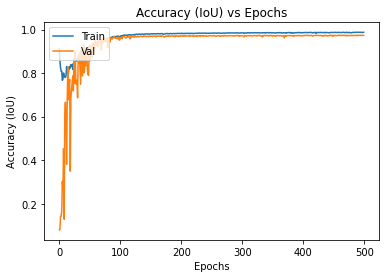

In [13]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('Accuracy (IoU) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (IoU)')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

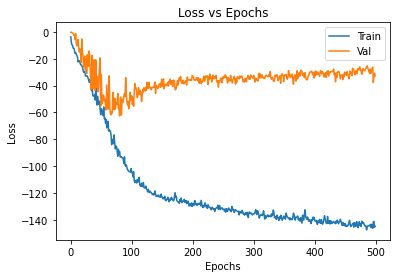

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

## Predicting mask images for test images

In [15]:
predicted = model.predict(lung_test)

## Visualizing sample lung, actual infection mask and predicted infection mask

IoU = tf.Tensor(0.9724225, shape=(), dtype=float32)


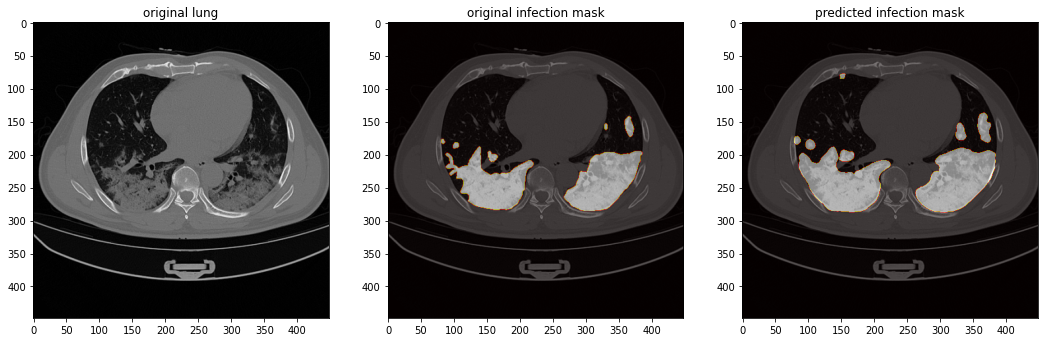

In [16]:
fig = plt.figure(figsize = (18,15))

i=48


plt.subplot(1,3,1)
plt.imshow(lung_test[i], cmap = 'gray')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(lung_test[i], cmap = 'gray')
plt.imshow(mask_test[i],alpha = 0.5, cmap = "hot")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(lung_test[i], cmap = 'gray')
plt.imshow(predicted[i],alpha = 0.5,cmap = "hot")
plt.title('predicted infection mask')

# Calculating IoU of sample infection prediction
y_true = mask_test[i]
y_pred = predicted[i]
y_pred = tf.round(tf.cast(y_pred, tf.int32))
intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
smooth = tf.ones(tf.shape(intersect))
k=10**-10
acc = tf.reduce_mean((intersect+k) / (union+k))
print("IoU =", acc)